In [1]:
import spacy
from spacy.tokens import Span
from spacy import displacy
import numpy as np
from transformers import pipeline

In [2]:
from transformers import (
    AutoConfig,
    AutoTokenizer,
    AutoModelForSeq2SeqLM
)

class PheePredictor:
    def __init__(self, model="hf_models/cross_flan_t5_large_instruction_finetune_phee2_spot_asoc_noise_0_order/cross1"):
        # self.generator = pipeline(task="text2text-generation",
        #              model=model, num_beams=num_beams)
        self.config = AutoConfig.from_pretrained(model)
        self.tokenizer = AutoTokenizer.from_pretrained(
                    model,
                    use_fast=True,
        )
        self.model = AutoModelForSeq2SeqLM.from_pretrained(model)
        self.model.cuda()
        
        self.prompt_template = "Extract the event information in the text. Event type: adverse event, potential therapeutic event Argument type: subject, age, gender, race, population, subject disorder, treatment, drug, dosage, route, duration, frequency, time elapsed, combination drug, treatment disorder,  effect Sentence: [SENT_PLC] . Output:"
        self.nlp = spacy.load("en_core_web_sm")


    

    @staticmethod
    def _preprocess_text(x_str):
        x_str = x_str.replace('[', '&(').replace(']', ')&')

        return x_str

    @staticmethod
    def _postprocess_text(x_str):        
        x_str = x_str.replace('</s>','').replace('<pad>','')
        # replace span split symbol and null symbol to be consistent with prompting inference
        x_str = x_str.replace('null', '<extra_id_6>').replace(':', '<extra_id_5>').replace(']', '<extra_id_1>').replace('[','<extra_id_0>')
        x_str = x_str.replace('&(', '[').replace(')&', ']')
        
        return x_str.strip()
    
    
    def predict(self, sentence):
        input_sent = self.prompt_template.replace('[SENT_PLC]', self._preprocess_text(sentence))
        inputs = self.tokenizer(input_sent, padding=True, return_tensors='pt').to(self.model.device)
        max_src_len = max_tgt_len = 512
        inputs['input_ids'] = inputs['input_ids'][:, :max_src_len]
        inputs['attention_mask'] = inputs['attention_mask'][:, :max_src_len]
        outputs = self.model.generate(
            input_ids=inputs['input_ids'],
            attention_mask=inputs['attention_mask'],
            max_length=max_tgt_len,
            do_sample = False,
            num_beams = 3,
            num_return_sequences = 1,
            return_dict_in_generate=True,
            output_scores=True,
        )

        # # If you sum the generated tokens' scores and apply the length penalty, you'll get the sequence scores.
        # # Tip: recomputing the scores is only guaranteed to match with `normalize_logits=False`. Depending on the
        # # use case, you might want to recompute it with `normalize_logits=True`.
        # transition_scores = self.model.compute_transition_scores(outputs.sequences, outputs.scores, outputs.beam_indices, normalize_logits=False)
        # sentence_score = np.average([score.cpu().numpy() for score in transition_scores[0]])
        # sentence_score = np.exp(sentence_score)
        sentence_score = np.exp(outputs.sequences_scores[0].item()) # two ways - same result

        generated_tokens = outputs.sequences[:, 1:]
        generated_sentence = self.tokenizer.decode(generated_tokens[0])
        generated_sentence = self._postprocess_text(generated_sentence)
        # for tok, score in zip(generated_tokens[0], transition_scores[0]):
        #     # | token | token string | logits | probability
        #     print(f"| {tok:5d} | {self.tokenizer.decode(tok):8s} | {score.numpy():.3f} | {np.exp(score.numpy()):.2%}")
        return {
            'record': generated_sentence,
            'score': sentence_score
        }

## test
# predictor = PheePredictor()
# sentence = "Heparin - dependent antibodies and thrombosis without heparin - induced thrombocytopenia ."
# predictor.predict(sentence)


In [3]:
from transformers import (
    AutoConfig,
    AutoTokenizer,
    AutoModelForSeq2SeqLM
)
import torch

class PheeScorer:
    def __init__(self, model="hf_models/cross_flan_t5_large_instruction_finetune_phee2_spot_asoc_noise_0_order/cross1"):
        # self.generator = pipeline(task="text2text-generation",
        #              model=model, num_beams=num_beams)
        self.config = AutoConfig.from_pretrained(model)
        self.tokenizer = AutoTokenizer.from_pretrained(
                    model,
                    use_fast=True,
        )
        self.model = AutoModelForSeq2SeqLM.from_pretrained(model)
        self.model.cuda()
        
        self.prompt_template = "Extract the event information in the text. Event type: adverse event, potential therapeutic event Argument type: subject, age, gender, race, population, subject disorder, treatment, drug, dosage, route, duration, frequency, time elapsed, combination drug, treatment disorder,  effect Sentence: [SENT_PLC] . Output:"
        self.nlp = spacy.load("en_core_web_sm")
        self.softmax = torch.nn.Softmax(dim=-1)

    @staticmethod
    def _preprocess_text(x_str):
        x_str = x_str.replace('[', '&(').replace(']', ')&')

        return x_str

    @staticmethod
    def _preprocess_target(x_str):        
        # replace span split symbol and null symbol to be consistent with prompting inference
        x_str = x_str.replace('[', '&(').replace(']', ')&')
        x_str = x_str.replace('<extra_id_6>', 'null').replace('<extra_id_5>',':').replace('<extra_id_1>',']').replace('<extra_id_0>','[')
        
        
        return x_str.strip()
    
    def get_score(self, sentence, target):

        target = self._preprocess_target(target)
        input_sent = self.prompt_template.replace('[SENT_PLC]', self._preprocess_text(sentence))
        inputs = self.tokenizer(input_sent, padding=False, max_length=512, truncation=True, return_tensors='pt').input_ids.to(self.model.device)
        targets = self.tokenizer(text_target=target, padding=False, max_length=512, truncation=True, return_tensors='pt').input_ids.to(self.model.device)

        with torch.no_grad():
            output = self.model(input_ids=inputs, labels=targets)
            loss = output.loss
            score = torch.exp(-loss).item()
            # log_probabilities = output.logits[0]
            # log_probabilities = self.softmax(log_probabilities)
            
        # # 计算概率
        # target_probabilities = []
        # for i, token_id in enumerate(targets[0]):
        #     target_probabilities.append(np.log(log_probabilities[i, token_id.item()].item()))
        # prob = np.exp(np.average(target_probabilities))

        return score

# ## test
# scorer = PheeScorer()
# sentence = "Physicians should be aware that PLP can occur after initiation of paclitaxel ."
# target = "<extra_id_0> <extra_id_0> adverse event <extra_id_5> occur <extra_id_0> treatment <extra_id_5> initiation of paclitaxel <extra_id_1> <extra_id_0> drug <extra_id_5> paclitaxel <extra_id_1> <extra_id_0> effect <extra_id_5> PLP <extra_id_1> <extra_id_1> <extra_id_1>"
# score = scorer.get_score(sentence, target)
# print(score)


In [4]:
import yaml
from collections import defaultdict
from scripts.eval_phee.sel2record_phee import *
from uie.sel2record.sel2record import SEL2Record
from scripts.eval_phee.phee_metric import compute_metric

class Evaluator:
    def __init__(self, schema_folder="data/converted_data/text2spotasoc/event/phee_2", label_config="dataset_processing/data_config/event/phee2.yaml"):
        self.schema_dict = SEL2Record.load_schema_dict(schema_folder)
        self.lb_mapper = self._get_label_mapper(label_config)


    @staticmethod
    def _get_label_mapper(config_file):
        with open(config_file) as fin:
            config = yaml.load(fin, Loader=yaml.FullLoader)

        mapper = {}
        for key, value in config['mapper'].items():
            mapper[value] = key

        return mapper
    
    
    def decode(self, pred):
        left_bracket = '【'
        right_bracket = '】'
        brackets = left_bracket + right_bracket

        pred = convert_bracket(pred)
        pred = clean_text(pred)
        try:
            if not check_well_form(pred):
                pred = add_bracket(pred)
            pred_tree = ParentedTree.fromstring(pred, brackets=brackets)

        except ValueError:
            logger.debug('ill-formed', pred)
            pred_tree = ParentedTree.fromstring(
                left_bracket + right_bracket,
                brackets=brackets
            )

        instance = {}
        instance['pred_spot'], instance['pred_asoc'], instance['pred_record'] = get_record_list(
                    sel_tree=pred_tree,
                    schema_dict=self.schema_dict
                )
        
        record = proprocessing_graph_record(
            instance,
            self.schema_dict
        )
        
        if len(record["event"]) > 1:
            is_mult = True
        else:
            is_mult = False

        out_record = defaultdict(list)
        evt_types = []
        for event in record["event"]:
            ev_type = self.lb_mapper[event['type']]
            evt_types.append(ev_type)
            if 'trigger' in event:
                out_record[ev_type+".Trigger"].append(event['trigger'])
            if 'roles' in event:
                for arg_type, arg_text in event['roles']:
                        out_record[ev_type+"."+self.lb_mapper[arg_type]].append(arg_text)

        return {
            'record': out_record,
            'is_mult': is_mult,
            'event_types': list(set(evt_types))
        }
    
    def compute_score(self, preds, golds):
        collects = []
        question_types = list(set(list(preds.keys())+list(golds.keys())))
        for qtype in question_types:
            if qtype == 'id': continue
            instance = {
                'id': None,
                'type': qtype,
                'predictions':[],
                'golds':[]
            }
            if qtype in preds:
                instance['predictions'] = preds[qtype]
            if qtype in golds:
                instance['golds'] = golds[qtype]

            collects.append(instance)

        result = compute_metric(instances=collects)

        return result
    
## test
# sentence = "Herein, we describe a 48 years old man presenting with rapidly progressive cognitive decline and hyponatremia diagnosed with anti LGI1 AE, occurring shortly after the second dose of mRNA COVID -19 vaccine and possibly representing a severe adverse event related to the vaccination."
# ft_predictor = PheePredictor()
# evaluator = Evaluator()
# pred = ft_predictor.predict(sentence)
# print(pred)
# pred_record = evaluator.decode(pred['record'])
# print(pred_record)
# score = evaluator.compute_score(pred_record['record'], pred_record['record'])
# print(score)
        

In [5]:
# sentence = "We present a case of ethylenediamine - induced delayed hypersensitivity reaction in a 46 - year - old woman who received parenteral aminophylline for an acute asthma exacerbation ."
# gold = "<extra_id_0> <extra_id_0> adverse event <extra_id_5> induced <extra_id_0> subject <extra_id_5> a 46 - year - old woman <extra_id_1> <extra_id_0> age <extra_id_5> 46 - year - old <extra_id_1> <extra_id_0> gender <extra_id_5> woman <extra_id_1> <extra_id_0> treatment <extra_id_5> ethylenediamine <extra_id_1> <extra_id_0> drug <extra_id_5> ethylenediamine <extra_id_1> <extra_id_0> effect <extra_id_5> delayed hypersensitivity reaction <extra_id_1> <extra_id_1> <extra_id_0> potential therapeutic event <extra_id_5> received <extra_id_0> subject <extra_id_5> a 46 - year - old woman <extra_id_1> <extra_id_0> age <extra_id_5> 46 - year - old <extra_id_1> <extra_id_0> gender <extra_id_5> woman <extra_id_1> <extra_id_0> subject disorder <extra_id_5> acute asthma exacerbation <extra_id_1> <extra_id_0> treatment <extra_id_5> parenteral aminophylline <extra_id_1> <extra_id_0> drug <extra_id_5> aminophylline <extra_id_1> <extra_id_0> route <extra_id_5> parenteral <extra_id_1> <extra_id_0> treatment disorder <extra_id_5> acute asthma exacerbation <extra_id_1> <extra_id_1> <extra_id_1>"
# # predictor = PheePredictor()
# scorer = PheeScorer()
# score = scorer.get_score(sentence, gold)
# print(score)

In [5]:
class SpacyVis:
    def __init__(self):
        self.nlp = spacy.blank("en")
        self.ruler = self.nlp.add_pipe("span_ruler", config={"phrase_matcher_attr": "LOWER"})
        self.schema_dict = SEL2Record.load_schema_dict("data/converted_data/text2spotasoc/event/phee_2")

    @staticmethod
    def _decode(pred, schema_dict):
        left_bracket = '【'
        right_bracket = '】'
        brackets = left_bracket + right_bracket

        pred = convert_bracket(pred)
        pred = clean_text(pred)
        try:
            if not check_well_form(pred):
                pred = add_bracket(pred)
            pred_tree = ParentedTree.fromstring(pred, brackets=brackets)

        except ValueError:
            logger.debug('ill-formed', pred)
            pred_tree = ParentedTree.fromstring(
                left_bracket + right_bracket,
                brackets=brackets
            )

        instance = {}
        instance['pred_spot'], instance['pred_asoc'], instance['pred_record'] = get_record_list(
                    sel_tree=pred_tree,
                    schema_dict=schema_dict
                )

        return instance

    def convert_to_record(self, output):
        pred_instance = self._decode(output, self.schema_dict)
        pred_record = proprocessing_graph_record(
            pred_instance,
            self.schema_dict
        )
        out_record = []
        for event in pred_record["event"]:
            out_record.append(event)

        return out_record

    def construct_labels(self, sentence, pred):
        patterns = []
        for eid, event in enumerate(pred):
            if event['type'] == 'adverse event':
                evt_str = 'ADE%d'%eid
            elif  event['type'] == 'potential therapeutic event':
                evt_str = 'PTE%d'%eid

            if "trigger" in event:
                patterns.append({"label": evt_str+".trigger", "pattern": event["trigger"]})

            for arg_type, arg_span in event['roles']:
                arg_type = "_".join(arg_type.split(" "))
                patterns.append({"label": evt_str+"."+arg_type, "pattern": arg_span})
            
        self.ruler.clear()
        self.ruler.add_patterns(patterns)
        sent_doc = self.nlp(sentence)

        sent_doc.spans["sc"] = []
        for span in sent_doc.spans["ruler"]:
            sent_doc.spans["sc"].append(Span(sent_doc, span.start, span.end, span.label_))

        return sent_doc
    
    
    
    def visualise_spans(self, sentence, output):
        record = self.convert_to_record(output)
        docs = self.construct_labels(sentence, record)
        displacy.render(docs, style="span")

In [6]:
# predictor = PheePredictor()
scorer = PheeScorer()
evaluator = Evaluator()


/home/u2081275/anaconda3/envs/llm/lib/python3.8/site-packages/spacy/util.py:910: UserWarning: [W095] Model 'en_core_web_sm' (3.5.0) was trained with spaCy v3.5.0 and may not be 100% compatible with the current version (3.6.1). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


In [7]:
visulaizer = SpacyVis()

In [8]:

from uie.extraction.record_schema import RecordSchema
from uie.extraction.noiser.ordered_spot_asoc_noiser import OrderedSpotAsocNoiser
from uie.extraction import constants
from uie.extraction.utils import convert_to_record_function
from uie.extraction.constants import BaseStructureMarker

record_schema = RecordSchema.read_from_file("data/converted_data/text2spotasoc/event/phee_2/record.schema")
spot_asoc_nosier = OrderedSpotAsocNoiser(
        schema=record_schema,
        spot_noise_ratio=0,  # noise add to record(target) during training
        asoc_noise_ratio=0,  # add null span 
        null_span=constants.null_span,
        ordered_prompt=True
    )

def regenerate_spot_asoc(record):
    # Inject rejection noise
    spot_label_list = record_schema.type_list.copy()
    asoc_label_list = record_schema.role_list.copy()
    for spot in record:
        if spot['label'] in spot_label_list:
            spot_label_list.remove(spot['label'])

        for asoc in spot['asoc']:
            if asoc[0] in asoc_label_list:
                asoc_label_list.remove(asoc[0])

    if spot_asoc_nosier is not None:
        record = spot_asoc_nosier.add_noise(record, spot_label_list=spot_label_list, asoc_label_list=asoc_label_list)
    
    # Generate new record
    record = convert_to_record_function['spotasoc'](
        record,
        structure_maker=BaseStructureMarker()
    )

    return record

In [9]:
## read and compute validatation data 

src_file = "dataset_processing/data/converted_data/text2spotasoc/event/phee2_cross1/val.json"
pred_file = "hf_models/flan_t5_large_instruction_finetune_phee2aug_repeat_asoc_noise_0_order_r3/eval_preds_seq2seq.txt"

# read the pred file
with open(pred_file, 'r') as f:
    pred_lines = f.readlines()

# print(len(pred_lines))

data = []
# read the src file
with open(src_file, 'r') as f:
    src_lines = f.readlines()
    assert(len(pred_lines) == len(src_lines))

    for src_line, pred_line in zip(src_lines, pred_lines):
        instance = json.loads(src_line)
        sentence = instance['text']
        gold = regenerate_spot_asoc(instance['spot_asoc'])
        pred = pred_line.strip()
        gold_record = evaluator.decode(gold)
        pred_record = evaluator.decode(pred)
        metrics = evaluator.compute_score(pred_record['record'], gold_record['record'])

        gold_score = scorer.get_score(sentence, gold)
        pred_score = scorer.get_score(sentence, pred)

        data.append(
            {
                "id": instance['text_id'],
                "sentence": instance['text'],
                "gold": gold,
                "pred": pred,
                "pred_score": pred_score,
                "gold_score": gold_score,
                'metrics': metrics,
                'is_mult': gold_record['is_mult'],
                'is_ade': 'Adverse_event' in gold_record['event_types'],
                'is_pte': 'Potential_therapeutic_event' in gold_record['event_types']
            }
        )

# print(data)


In [10]:
## read and compute training data 
predictor = PheePredictor()
src_file = "dataset_processing/data/converted_data/text2spotasoc/event/phee2_cross1/train.json"

data = []
# read the src file
with open(src_file, 'r') as f:
    src_lines = f.readlines()
    for src_line in src_lines:
        instance = json.loads(src_line)
        sentence = instance['text']
        gold = regenerate_spot_asoc(instance['spot_asoc'])
        pred_result = predictor.predict(sentence)
        pred = pred_result['record']
        gold_record = evaluator.decode(gold)
        pred_record = evaluator.decode(pred)
        metrics = evaluator.compute_score(pred_record['record'], gold_record['record'])

        gold_score = scorer.get_score(sentence, gold)
        pred_score = pred_result['score']

        data.append(
            {
                "id": instance['text_id'],
                "sentence": instance['text'],
                "gold": gold,
                "pred": pred,
                "pred_score": pred_score,
                "gold_score": gold_score,
                'metrics': metrics,
                'is_mult': gold_record['is_mult'],
                'is_ade': 'Adverse_event' in gold_record['event_types'],
                'is_pte': 'Potential_therapeutic_event' in gold_record['event_types']
            }
        )

# print(data)
""

/home/u2081275/anaconda3/envs/llm/lib/python3.8/site-packages/spacy/util.py:910: UserWarning: [W095] Model 'en_core_web_sm' (3.5.0) was trained with spaCy v3.5.0 and may not be 100% compatible with the current version (3.6.1). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


In [11]:
# write the data to json file
chosen_metric = ["CLS_Arguments_EM_F1", "CLS_MainArgs_EM_F1", "CLS_SubArgs_EM_F1",
                 "CLS_Subject_EM_F1", "CLS_Treatment_EM_F1", "CLS_Effect_EM_F1",
                 "CLS_Subject.Disorder_EM_F1","CLS_Subject.Population_EM_F1",
                 "CLS_Subject.Age_EM_F1","CLS_Subject.Gender_EM_F1","CLS_Subject.Race_EM_F1",
                 "CLS_Treatment.Time_elapsed_EM_F1","CLS_Treatment.Drug_EM_F1",
                 "CLS_Treatment.Disorder_EM_F1", "CLS_Treatment.Dosage_EM_F1",
                 "CLS_Treatment.Duration_EM_F1","CLS_Treatment.Route_EM_F1",
                 "CLS_Treatment.Freq_EM_F1", "CLS_Combination.Drug_EM_F1"]
for item in chosen_metric.copy():
    chosen_metric.append(item.replace('EM_F1','MICRO_F1'))
with open('output/prob_analysis/cross/cross_1/train_score.json', 'w') as f:
    for d in data:
        line = {
            "id": d["id"],
            "sentence": d["sentence"],
            "gold": d["gold"],
            "pred": d["pred"],
            "pred_score": float(d["pred_score"]),
            "gold_score": float(d["gold_score"]),
            # 'metrics': metrics,
            'is_mult': 1 if d['is_mult'] else 0,
            'is_ade': 1 if d['is_ade'] else 0,
            'is_pte': 1 if d['is_pte'] else 0
        }
        for k, v in d["metrics"].items():
            if k in chosen_metric:
                line[k] = float(v)
        
        f.write(json.dumps(line)+"\n")

In [9]:
import json
# load the data to json file
loaded_data = []
with open('output/prob_analysis/train_aug_constrain_drug_scores.json', 'r') as f:
    for line in f.readlines():
        loaded_data.append(json.loads(line))

In [10]:
import pandas as pd

frame = []
for d in loaded_data:
    out = {
        'pred-gold': d['pred_score'] - d['gold_score'],
        'is_mult_or_pte': 1 if d['is_pte'] or d['is_mult'] else 0,
        'EM_F1': d['CLS_Arguments_EM_F1']/100,
        'Token_F1': d['CLS_Arguments_MICRO_F1']/100,
    }
    out.update(d)
    frame.append(out)

frame = pd.DataFrame(frame)
    

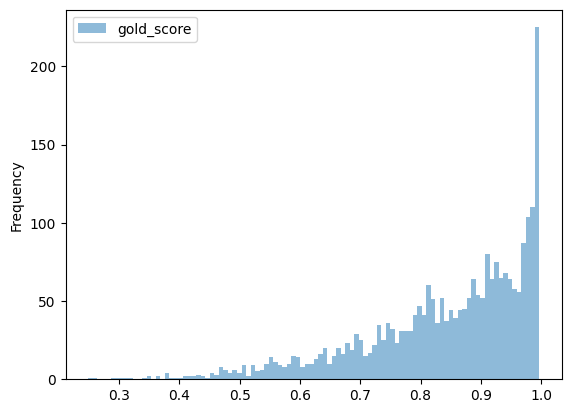

In [27]:
import matplotlib.pyplot as plt

# frame.plot.scatter(x="pred_score", y="gold_score")
# plt.show()

ax = frame[['gold_score']].plot.hist(bins=100, alpha=0.5)


In [11]:
mean_pred = frame['pred_score'].mean()
mean_gold = frame['gold_score'].mean()
mean_token_f1 = frame['Token_F1'].mean()
print("mean_pred", mean_pred)
print("mean_gold", mean_gold)
print("mean_token_f1", mean_token_f1)


mean_pred 0.980345150630505
mean_gold 0.8413392568069568
mean_token_f1 0.7850164794735887


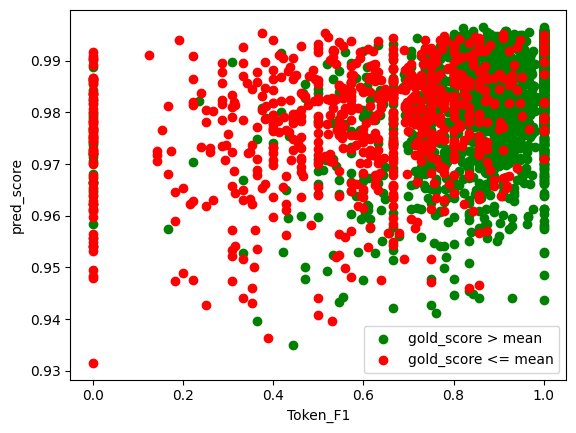

In [13]:
import pandas as pd
import matplotlib.pyplot as plt

# 假设你已经有一个名为df的Pandas DataFrame，包含"a"、"b"和"c"属性

# 创建两种颜色的子集
pos = frame[frame['gold_score'] > mean_token_f1]
neg = frame[frame['gold_score'] <= mean_token_f1]

# 绘制散点图
plt.scatter(pos['Token_F1'], pos['pred_score'], c='green', label='gold_score > mean')
plt.scatter(neg['Token_F1'], neg['pred_score'], c='red', label='gold_score <= mean')

# 添加标签和图例
plt.xlabel('Token_F1')
plt.ylabel('pred_score')
plt.legend()

# 显示图形
plt.show()

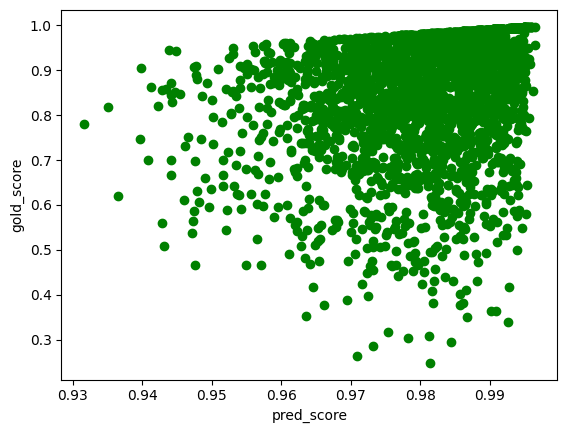

In [14]:
plt.scatter(frame['pred_score'], frame['gold_score'], c='green')
# 添加标签和图例
plt.xlabel('pred_score')
plt.ylabel('gold_score')


# 显示图形
plt.show()

In [49]:
# mean_pred = 0.975
# mean_gold= 0.9
case = frame[(frame['Token_F1'] > mean_token_f1) & (frame['pred_score'] > mean_pred)]
stat = []
stat.append({
    'pred < mean': 1, 
    'gold < mean': 1,
    'token_f1 < mean': 1,
    'count': len(frame[(frame['pred_score'] < mean_pred) & (frame['gold_score'] < mean_gold) & (frame['Token_F1'] < mean_token_f1)])
})

stat.append({
    'pred < mean': 1, 
    'gold < mean': 1,
    'token_f1 < mean': 0,
    'count': len(frame[(frame['pred_score'] < mean_pred) & (frame['gold_score'] < mean_gold) & (frame['Token_F1'] >= mean_token_f1)])
})

stat.append({
    'pred < mean': 1, 
    'gold < mean': 0,
    'token_f1 < mean': 1,
    'count': len(frame[(frame['pred_score'] < mean_pred) & (frame['gold_score'] >= mean_gold) & (frame['Token_F1'] < mean_token_f1)])
})

stat.append({
    'pred < mean': 1, 
    'gold < mean': 0,
    'token_f1 < mean': 0,
    'count': len(frame[(frame['pred_score'] < mean_pred) & (frame['gold_score'] >= mean_gold) & (frame['Token_F1'] >= mean_token_f1)])
})

stat.append({
    'pred < mean': 0, 
    'gold < mean': 1,
    'token_f1 < mean': 1,
    'count': len(frame[(frame['pred_score'] >= mean_pred) & (frame['gold_score'] < mean_gold) & (frame['Token_F1'] < mean_token_f1)])
})

stat.append({
    'pred < mean': 0, 
    'gold < mean': 1,
    'token_f1 < mean': 0,
    'count': len(frame[(frame['pred_score'] >= mean_pred) & (frame['gold_score'] < mean_gold) & (frame['Token_F1'] >= mean_token_f1)])
})

stat.append({
    'pred < mean': 0, 
    'gold < mean': 0,
    'token_f1 < mean': 1,
    'count': len(frame[(frame['pred_score'] >= mean_pred) & (frame['gold_score'] >= mean_gold) & (frame['Token_F1'] < mean_token_f1)])
})

stat.append({
    'pred < mean': 0, 
    'gold < mean': 0,
    'token_f1 < mean': 0,
    'count': len(frame[(frame['pred_score'] >= mean_pred) & (frame['gold_score'] >= mean_gold) & (frame['Token_F1'] >= mean_token_f1)])
})

stat = pd.DataFrame(stat)
stat

,pred < mean,gold < mean,token_f1 < mean,count
0,1,1,1,470
1,1,1,0,212
2,1,0,1,113
3,1,0,0,408
4,0,1,1,211
5,0,1,0,195
6,0,0,1,94
7,0,0,0,1195


In [47]:
print(frame['pred_score'].corr(frame['gold_score']))
print(frame['pred_score'].corr(frame['Token_F1']))
print(frame['gold_score'].corr(frame['Token_F1']))

0.4080180404818222
0.3969215361824466
0.5427815505087794


In [30]:
piece = frame[(frame['pred_score'] < mean_pred) & (frame['gold_score'] >= mean_gold) ]
piece = piece.sort_values(by=['Token_F1'], ascending=True)
piece.head()

,pred-gold,is_mult_or_pte,EM_F1,Token_F1,id,sentence,gold,pred,pred_score,gold_score,...,CLS_Subject.Age_EM_F1,CLS_Subject.Age_MICRO_F1,CLS_Treatment.Dosage_EM_F1,CLS_Treatment.Dosage_MICRO_F1,CLS_Treatment.Route_EM_F1,CLS_Treatment.Route_MICRO_F1,CLS_Treatment.Freq_EM_F1,CLS_Treatment.Freq_MICRO_F1,CLS_Subject.Race_EM_F1,CLS_Subject.Race_MICRO_F1
2276,0.131397,1,0.0,0.0,21597286_2_0,We report a case of a potential drug - drug in...,<extra_id_0> <extra_id_0> potential therapeuti...,<extra_id_0> <extra_id_0> adverse event <extra...,0.975533,0.844136,...,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
1298,0.103528,1,0.0,0.0,9883483_3_0,We report on a 45 - year - old male who exhibi...,<extra_id_0> <extra_id_0> potential therapeuti...,<extra_id_0> <extra_id_0> adverse event <extra...,0.962251,0.858722,...,0.0,0.0,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
1323,0.049893,1,0.0,0.0,23552010_2_0,A patient was administered Heparin and subsequ...,<extra_id_0> <extra_id_0> potential therapeuti...,<extra_id_0> <extra_id_0> adverse event <extra...,0.962263,0.912370,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
115,0.021765,1,0.0,0.0,14526130_2_0,We report the case of a 45 year old patient wh...,<extra_id_0> <extra_id_0> potential therapeuti...,<extra_id_0> <extra_id_0> adverse event <extra...,0.970629,0.948864,...,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
401,0.083991,1,0.0,0.0,11834188_4_0,We reported a case of a patient who experience...,<extra_id_0> <extra_id_0> potential therapeuti...,<extra_id_0> <extra_id_0> adverse event <extra...,0.961025,0.877033,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [22]:
idx = 2271
piece = frame

print(piece['CLS_Arguments_EM_F1'][idx])
print(piece['CLS_Arguments_MICRO_F1'][idx])
print(piece['pred_score'][idx])
print(piece['gold_score'][idx])

sentence, pred, gold = piece['sentence'][idx], piece['pred'][idx], piece['gold'][idx]

print(sentence)
print("Prediction:")
visulaizer.visualise_spans(sentence, pred)
print("Annotation: ")
visulaizer.visualise_spans(sentence, gold)



62.5
66.66666666666667
0.9422303619350917
0.8203414678573608
After receiving concomitant chemoirradiation , the patient experienced severe nausea and vomiting , and oxaliplatin was administered to alleviate the symptoms .
Prediction:


Annotation: 


In [ ]:
frame = frame.sort_values(by=['pred-gold'], ascending=False)
frame.head()

In [26]:
data[idx]['is_pte']

True

In [27]:
# select pred < mean， gold > mean 的例子作为增强训练的例子
selected_ids = frame[(frame['pred_score'] < mean_pred)]['id'].values

with open('output/prob_analysis/train_rep_unc_pred.json', 'w') as fw:
    with open('data/converted_data/text2spotasoc/event/phee_2_aug_constrain/train.json', 'r') as f:
        for line in f.readlines():
            instance = json.loads(line)
            if instance['text_id'] in selected_ids:
                fw.write(line)



In [ ]:
import json
def check_subset_cases(src_file):
    single_cases = 0
    mult_cases = 0
    pte_cases = 0
    ade_cases = 0
    # src_file = "data/converted_data/text2spotasoc/event/phee_2_aug_constrain/train.json"
    # src_file = "output/prob_analysis/train_rep.json"

    mult_list = []

    with open(src_file, 'r') as f:
        for line in f.readlines():
            instance = json.loads(line)
            if len(instance['event']) > 1:
                mult_cases += 1
                mult_list.append(instance['text_id'])
            else:
                single_cases += 1

            if "adverse event" in instance['spot']:
                ade_cases += 1
            if "potential therapeutic event" in instance['spot']:
                pte_cases += 1

    print("total cases:", single_cases+mult_cases)
    print("single_cases", single_cases)
    print("mult_cases", mult_cases)
    print("pte_cases", pte_cases)
    print("ade_cases", ade_cases)

    return mult_list


train_mult = check_subset_cases("data/converted_data/text2spotasoc/event/phee_2_aug_constrain/train.json")  
rep_mult = check_subset_cases("output/prob_analysis/train_rep.json") 

for tid in train_mult:
    if tid not in rep_mult:
        print(tid)

In [19]:
with open("output/prob_analysis/train_aug_constrain_drug_scores.json", 'r') as f:
    c_mult = 0
    c_single = 0
    c_ade = 0
    c_pte = 0
    
    for lid, line in enumerate(f.readlines()):
        instance = json.loads(line)
        is_mult = instance['is_mult']
        is_ade = instance['is_ade']
        is_pte = instance['is_pte']
        pred_score = instance['pred_score']
        gold_score = instance['gold_score']
        
        # if gold_score >= 0.9:
        if is_mult:
            c_mult += 1
            print(lid, instance['id'])
        else:
            c_single += 1
        if is_ade:
            c_ade += 1
        if is_pte:
            c_pte += 1

    print("c_mult", c_mult)
    print("c_single", c_single)
    print("c_ade", c_ade)
    print("c_pte", c_pte)


7 2369419_4_0
172 19034138_2_0
203 10650865_1_0
271 21751542_5_0
285 3301251_2_0
294 18067642_2_0
314 7752014_3_0
393 10891991_7_0
400 1569260_1_0
468 15628319_1_0
473 1295628_3_0
537 12581772_2_0
599 9846036_4_0
640 14998226_10_0
641 15359206_2_0
661 7893301_1_0
770 9494448_5_0
878 11722307_4_0
888 12221670_3_0
944 2894766_1_0
959 9920368_1_0
995 15311565_1_0
1051 7814182_2_0
1073 17667216_2_0
1081 424824_1_0
1116 7416268_3_0
1157 8244201_1_0
1179 8641617_1_0
1203 9433539_1_0
1207 12365708_5_0
1211 7538828_8_0
1225 19892516_4_0
1243 14960440_1_0
1257 15907341_2_0
1261 7653281_8_0
1287 9111724_1_0
1305 1751354_3_0
1306 21751692_4_0
1318 14690166_5_0
1330 19531695_14_0
1355 17060191_3_0
1377 8530331_6_0
1396 6245286_2_0
1405 9494448_2_0
1420 15671134_3_0
1475 8239963_2_0
1479 7900744_5_0
1487 10749332_2_0
1550 16416684_1_0
1591 18691992_6_0
1595 10589077_3_0
1622 15671134_1_0
1628 20118434_1_0
1642 11122162_1_0
1645 7962394_3_0
1769 9554064_3_0
1789 8530331_5_0
1798 847572_2_0
1806 1088